In [1]:
import pandas as pd
import numpy as np
from anomaly_data import preprocess_data
train_loader, test_loader, test_window, labels = preprocess_data('C:/Users/johnn/cam_time_series_new/inputs/train.csv', 'C:/Users/johnn/cam_time_series_new/inputs/test.csv', 'C:/Users/johnn/cam_time_series_new/inputs/test_label.csv', 300, 0.02, 0.1)

c:\Users\johnn\anaconda3\lib\site-packages\torch\onnx\_internal\_beartype.py:30: UserWarning: module 'beartype.roar' has no attribute 'BeartypeDecorHintPep585DeprecationWarning'
  warnings.warn(f"{e}")


In [2]:
windows, seq_len, dim = test_window.shape
test_window = test_window.reshape(windows, dim, seq_len)

Build the model and Train the Model

In [3]:
from CNN_model import ConvNet2D, ModelCNN
modelarch = ConvNet2D(seq_len,dim, dim,2).to('cpu')
model = ModelCNN(modelarch, 'cpu')

In [ ]:
# If need train the model fundamentally again:
# model.train(num_epochs=10, dataloader_cl1=train_loader,dataloader_cl1_test=test_loader)
# model.save('model.pt')

Load the model and generate DCAM for test dataset:

In [4]:
import torch
file_path = 'model.pt'
model = torch.load(file_path)

In [ ]:
last_conv_layer = model._modules['layer3']
fc_layer_name = model._modules['fc1']
total_window, dim, seq_len = test_window.shape

result = np.zeros((total_window + seq_len, dim))

for i in range(total_window):
    instance = np.array(test_window[i, :, :]).reshape(25, 300)

    # instance = np.array(test_window[i, :, :]).reshape(25, 300)
    print(f"window {i} is calculating")
    
    # DCAM_m = DCAM(model, 'cpu',last_conv_layer=last_conv_layer,fc_layer_name=fc_layer_name)
    
    dcam,permutation_success = DCAM_m.run(
        instance = instance,
        nb_permutation = 200,
        label_instance = 1
    )
    dcam = dcam.reshape(300, 25)
    result[i: i + seq_len, :] = result[i: i + seq_len, :] + dcam

Compute the result and observe which one

In [32]:
# Result has been pre-computed as below
result = np.load('value.npy')

# Magnify the effect of the first sequence length
for i in range(seq_len):
    value = seq_len - i
    result[i, :] = result[i, :] * value
    result[-i, :] = result[-i, :] * value

Visualisation in overall dimensions:

<Axes: >

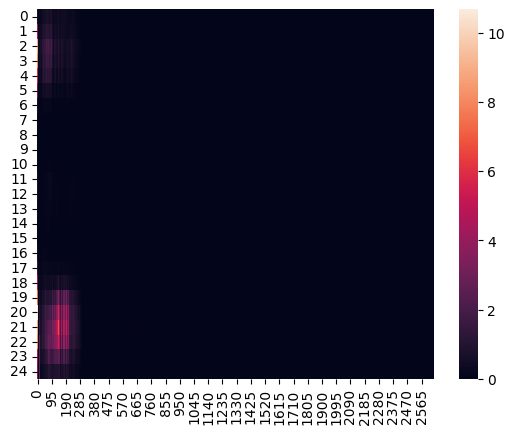

In [8]:
import seaborn as sns
sns.heatmap(np.transpose(result))

Visualisation in averaged dimension

<Axes: >

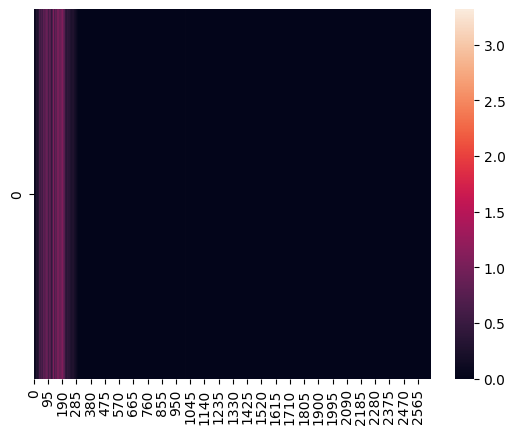

In [17]:
total_window, dim, seq_len = test_window.shape
agg_values = np.mean(result, axis = 1).reshape(1, total_window + seq_len)
sns.heatmap(agg_values)

Visualisation for Anomaly Detection

In [19]:
!pip install plotly

In [42]:
import plotly.graph_objects as go
import numpy as np

# Assuming you have the 'DCAM' array available

data = np.transpose(test_window[0, :, :])

start = 80
end = 100

DCAM_data = result

timesteps = 300
features = 25
# Create x-axis values (timesteps)
x = np.arange(start, end)

# Create a line trace for each feature in the 'data' array
traces = []
for i in range(features):
    trace = go.Scatter(
        x=x,
        y=data[start:end, i],
        mode='lines',
        name=f'Feature {i+1}'
    )
    traces.append(trace)

# Create a line trace for each feature in the 'DCAM' array
DCAM_traces = []
for i in range(features):
    trace = go.Scatter(
        x=x,
        y=DCAM_data[start:end, i],
        mode='lines',
        name=f'DCAM Feature {i+1}'
    )
    DCAM_traces.append(trace)

# Create the layout for the main data graph
layout = go.Layout(
    title='Line Graph - Data',
    xaxis=dict(title='Timestep'),
    yaxis=dict(title='Value')
)

# Create the figure for the main data graph and plot the traces
fig = go.Figure(data=traces, layout=layout)

# Add the DCAM traces to the main data graphs
for trace in DCAM_traces:
    fig.add_trace(trace)

fig.show()

# Create the layout for the DCAM graph
DCAM_layout = go.Layout(
    title='Line Graph - DCAM',
    xaxis=dict(title='Timestep'),
    yaxis=dict(title='DCAM Value')
)

# Create the figure for the DCAM graph and plot the DCAM traces
DCAM_fig = go.Figure(data=DCAM_traces, layout=DCAM_layout)
DCAM_fig.show()

(2650, 25)
